c:\python\lib\site-packages\pandas\core\generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
c:\python\lib\site-packages\pandas\core\series.py:4523: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,
c:\python\lib\site-packages\pandas\core\series.py:4523: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,
c:\python\lib\site

any nan:  False
nan sum open_covid_region_code     0
country_region_code        0
country_region             0
sub_region_1               0
sub_region_1_code          0
                          ..
symptom:Weight gain        0
symptom:Xeroderma          0
symptom:hyperhidrosis      0
hospitalized_cumulative    0
hospitalized_new           0
Length: 193, dtype: int64
any nan cluster dtaset:  False
nan sum dataset open_covid_region_code    0
country_region_code       0
country_region            0
sub_region_1              0
sub_region_1_code         0
                         ..
symptom:Wart              0
symptom:Weight gain       0
symptom:Xeroderma         0
symptom:hyperhidrosis     0
date                      0
Length: 191, dtype: int64
       open_covid_region_code country_region_code country_region sub_region_1  \
count                     434                 434            434          434   
unique                     14                   1              1           14   
top    

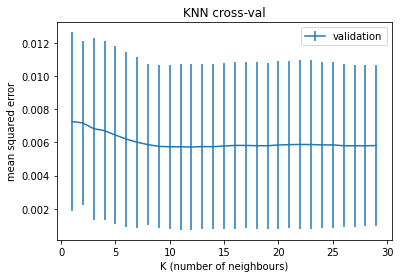

Report: We choose the model with the smallest validation error (an alternative is to choose the simplest model - larger K and smoother decision boundary consequently -  within one standard deviation)
k and min err:  12 0.005720305265695143
err tree cross val:  [[0.00145563]
 [0.01524366]
 [0.02592499]
 [0.00443702]
 [0.01981573]]
mean err tree cross_val:  0.013375408644367962


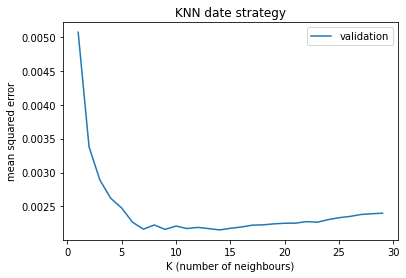

Report: We choose the model with the smallest validation error (an alternative is to choose the simplest model - larger K and smoother decision boundary consequently -  within one standard deviation)
k and min err:  14 0.0021545941817409002
Mean Absolute Error: 0.036726304087924995
Mean Squared Error: 0.002660848078823324
Root Mean Squared Error: 0.05158340894922828
err decision tree by date:  0.002660848078823324
variance:  [0.38408167 0.15651706 0.07017481 0.04731291 0.03086474 0.01513891
 0.0133955  0.00992859 0.00904135 0.00813526 0.00761265 0.00715458
 0.00658774 0.00624518 0.00607892 0.00583567 0.00561368 0.00544453
 0.00518967 0.00507212 0.00485309 0.00453946 0.00440934 0.00434578
 0.00427824 0.00401651 0.00393595 0.00381725 0.00365062 0.00363935
 0.00340097 0.00335289 0.00326067 0.00321225 0.00313575 0.00300585
 0.00295941 0.00287846 0.0027349  0.00268878 0.00263377 0.00257655
 0.00250827 0.00245209 0.0023948  0.00232691 0.00227653 0.00227044
 0.00220931 0.0021109  0.00210675 0

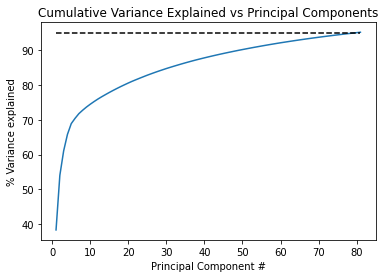

pca shape:  (434, 81)


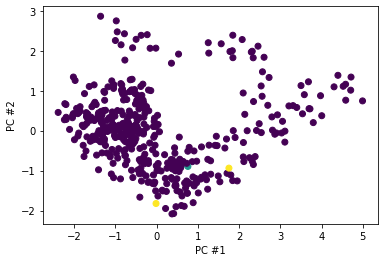

These principal components are calculated only from features and no information fromclasses are considered. So PCA is unsupervised method andit’s difficult to interpret the two axes as they are some complex mixtureof the original features


LinAlgError: SVD did not converge

In [6]:
import numpy as np
import pandas as pd
from pandas.tseries.frequencies import to_offset
import csv
import datetime
from sklearn import neighbors
import matplotlib as matplotlib
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from pydotplus import graph_from_dot_data

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA as PCA_KM
import matplotlib.pyplot as plt_km

from sklearn.decomposition import PCA
from sklearn import metrics

#matplotlib.use('TkAgg')
%matplotlib notebook
%matplotlib inline

# define a function for the MSE loss
loss = lambda y, yh: np.mean((y - yh) ** 2)


class Loader:
    def __init__(self):
        dataset_1_weekly_url = "https://raw.githubusercontent.com/google-research/open-covid-19-data/master/data/exports/search_trends_symptoms_dataset/United%20States%20of%20America/2020_US_weekly_symptoms_dataset.csv"
        dataset_1_weekly_local = '2020_US_weekly_symptoms_dataset.csv'
        dataset_search_weekly_reference = pd.read_csv(dataset_1_weekly_url)
        # here we store the codes (us-al, us-ny, etc) from dataset1, weekly version
        # we do that because if we use the regions from the daily dataset we have too many 0 (zero) values in the 2 hospitalization columns from the other dataset, after merging both datasets
        self.covid_region_codes = dataset_search_weekly_reference.open_covid_region_code.unique()

    # load the datasets
    def get_merged_datasets(self):
        dataset_1_daily_url = 'https://raw.githubusercontent.com/google-research/open-covid-19-data/master/data/exports/search_trends_symptoms_dataset/United%20States%20of%20America/2020_US_daily_symptoms_dataset.csv'
        dataset_1_daily_local = '2020_US_daily_symptoms_dataset.csv'
        self.dataset_search = pd.read_csv(dataset_1_daily_url)

        dataset_2_url = 'https://raw.githubusercontent.com/google-research/open-covid-19-data/master/data/exports/cc_by/aggregated_cc_by.csv'
        dataset_2_local = 'hospitalizations_aggregated_cc_by.csv'
        self.dataset_hospitalization = pd.read_csv(dataset_2_url, engine='python')

        self.dataset_hospitalization, self.covid_region_codes = self._eliminate_regions_with_zero_value_for_label_class()
        self.dataset_hospitalization = self._get_regions_for_dataset2_from_dataset01()
        self.dataset_hospitalization = self._remove_missing_data(self.dataset_hospitalization)
        self.dataset_hospitalization = self._normalize_dataset(self.dataset_hospitalization)
        self.dataset_hospitalization = self._collapse_dataset_to_weekly_resolution(
            self.dataset_hospitalization, self._get_logic_stru_for_dataset02())


        self.dataset_search = self._remove_missing_data(self.dataset_search)
        self.dataset_search = self._normalize_dataset_by_region(self.dataset_search)
        self.dataset_search = self._collapse_dataset_to_weekly_resolution(
            self.dataset_search, self._get_logic_stru_for_dataset01(self.dataset_search))

        # we create a dataset for clustering only, efore mergin with hospitalization
        self.dataset_cluster = self.dataset_search

        # we concatenate dataset2 into 1;
        # from now on dataset_search is merged with columns from hospitalization dataset
        self.dataset_search = self._concatenate(self.dataset_search, self.dataset_hospitalization)

        self.dataset_search.reset_index(drop=True)
        self.dataset_search.index = range(len(self.dataset_search))

        # delete rows before 2020/Mar/02, which is the first date in dataset 2, after bringing to weekly
        # resolution;
        # also delete rows after 2020/Sep/28, which is the last date for dataset1, weekly version
        # this way we avoid having nan values in those rows after merging both datasets. We just delete them.
        self.dataset_search = self._eliminate_rows_per_date(self.dataset_search, 2020, 3, 2, before=True)
        self.dataset_search = self._eliminate_rows_per_date(self.dataset_search, 2020, 9, 28, before=False)

        self.dataset_cluster = self._eliminate_rows_per_date(self.dataset_cluster, 2020, 3, 2, before=True)
        self.dataset_cluster = self._eliminate_rows_per_date(self.dataset_cluster, 2020, 9, 28, before=False)

        # we do a second normalization after merging the dataset to bring them between 0 and 1 values
        self.dataset_search = self._normalize_dataset(self.dataset_search, 'minmax')

        # replace nan values with mean for each feature, if necessary
        self.dataset_search.fillna(self.dataset_search.mean(), inplace=True)

        # reset indexes
        self.dataset_search.reset_index(drop=True)
        self.dataset_search.index = range(len(self.dataset_search))
        return self.dataset_search

    def print_basic_stats(self):
        print('any nan: ', self.dataset_search.isnull().values.any())
        print('nan sum', self.dataset_search.isnull().sum())
        print('any nan cluster dtaset: ', self.dataset_cluster.isnull().values.any())
        print('nan sum dataset', self.dataset_cluster.isnull().sum())
        print(self.dataset_search.describe(include='all'))

    def _normalize_dataset(self, dataset, norm_type='standard'):
        scaler = StandardScaler() if norm_type == 'standard' else MinMaxScaler()

        numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

        frame = dataset
        # first we replace nan values with mean for each feature
        frame.fillna(frame.mean(), inplace=True)
        frame.reset_index(drop=True)
        frame.index = range(len(frame))

        # we have to split numeric and non-numeric data because StandardScaler
        # works with numerical data only
        numeric_frame = frame.select_dtypes(include=numerics)
        non_numeric_frame = frame.select_dtypes(exclude=numerics)
        #non_numeric_frame.reset_index()
        scaled_features_array = scaler.fit_transform(numeric_frame.values)
        # StandardScaler returns a numpy array so we have to re-create the dataframe
        scaled_features_frame = pd.DataFrame(data=scaled_features_array[:, :],
                                             columns=numeric_frame.columns)
        # we concatenate back numerical and non-numerical columns
        frame_normalized = pd.concat([non_numeric_frame, scaled_features_frame],
                                     axis=1).reindex(frame.index)
        return frame_normalized


    def _normalize_dataset_by_region(self, dataset):
        numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
        frames = []
        # # we get the rows by code/region
        for code in self.covid_region_codes:
            frame = dataset.loc[dataset.open_covid_region_code == code]
            # first we replace nan values with mean for each feature
            frame.fillna(frame.mean(), inplace=True)
            frame.reset_index(drop=True)
            frame.index = range(len(frame))

            # we have to split numeric and non-numeric data because StandardScaler
            # works with numerical data only
            numeric_frame = frame.select_dtypes(include=numerics)
            non_numeric_frame = frame.select_dtypes(exclude=numerics)
            scaled_features_array = StandardScaler().fit_transform(numeric_frame.values)
            # StandardScaler returns a numpy array so we have to re-create the dataframe
            scaled_features_frame = pd.DataFrame(data=scaled_features_array[:, :],
                                                columns = numeric_frame.columns)
            # we concatenate back numerical and non-numerical columns
            frame_normalized = pd.concat([non_numeric_frame, scaled_features_frame],
                                         axis='columns').reindex(frame.index)
            frames.append(frame_normalized)

        # we concatenate back all rows per code/region
        normalized_dataset = pd.concat(frames, axis=0)
        return normalized_dataset

    def _eliminate_regions_with_zero_value_for_label_class(self):
        frames = []
        # we get the rows by code
        for code in self.covid_region_codes:
            frame = self.dataset_hospitalization.loc[self.dataset_hospitalization['open_covid_region_code'] == code]
            # we keep only regions which have at least 1 non zero value for
            # 'hospitalized_new' column, our label
            arr = frame['hospitalized_new'].to_numpy()
            if not ((0 == arr).all()):
                frames.append(frame)

        # we concatenate back the rows. We now have dataset 2 with same regions as dataset 1
        hospitalization_dataset = pd.concat(frames, axis=0)
        return hospitalization_dataset, hospitalization_dataset.open_covid_region_code.unique()

    def _eliminate_rows_per_date(self, dataset, year, month, day, before=True):
        target_date = datetime.date(year, month, day)
        target_date = pd.to_datetime(target_date)  #
        if before:
            indexes = dataset[dataset['date'] < target_date].index
        else:
            indexes = dataset[dataset['date'] > target_date].index
        dataset.drop(indexes, inplace=True)
        return dataset

    # in order to resample to weekly resolution we need to define some rules
    # basically we sum the values of symptoms columns
    # for the other columns we take the value of the first day of week
    def _get_logic_stru_for_dataset01(self, dataset):
        logic_dict = {}
        column_names = list(dataset.columns.values)
        for value in column_names:
            if value == 'date':
                continue
            value = str(value)
            logic_dict[value] = 'sum' if value.startswith('symptom') else 'first'

        return logic_dict

    def _get_logic_stru_for_dataset02(self):
        logic_dict = {
            'open_covid_region_code': 'first',
            'region_name': 'first',
            'hospitalized_cumulative': 'last',
            'hospitalized_new': 'sum'
        }

        return logic_dict

    # we take dataset 2 and extract from it the rows by the the regions present in dataset 1
    # this step is important for merging in the end
    def _get_regions_for_dataset2_from_dataset01(self):
        # get the codes present in dataset 1
        frames = []
        # we get the rows by code
        for code in self.covid_region_codes:
            frame = self.dataset_hospitalization.loc[self.dataset_hospitalization['open_covid_region_code'] == code]
            frames.append(frame)

        # we concatenate back the rows. We now have dataset 2 with same regions as dataset 1
        return pd.concat(frames, axis=0)

    # remove missing data with x% threshold
    def _remove_missing_data(self, dataframe):
        threshold = len(dataframe.index) * 0.95
        # drop columns
        dataframe.dropna(axis=1, inplace=True, thresh=threshold)
        # # drop rows
        # self.dataset_hospitalization.dropna(axis=0, inplace=True, thresh=threshold)

        return dataframe

    # change dataset time reslution from day to week
    def _collapse_dataset_to_weekly_resolution(self, dataset, logic):
        frames = []
        # get rows by region and resample for each region
        for code in self.covid_region_codes:
            frame = dataset.loc[dataset.open_covid_region_code == code]
            frame.date = pd.to_datetime(frame['date'])
            frame.set_index('date')

            # we resample to Mondays
            resampled_dataframe = frame.resample('W-MON', closed='left', on='date').apply(logic)
            loffset = '-7d'
            resampled_dataframe.index = resampled_dataframe.index + to_offset(loffset)

            # we do that here to have 'date' as column.
            resampled_dataframe['date'] = resampled_dataframe.index.values

            frames.append(resampled_dataframe)

        # put all the regions back together
        return pd.concat(frames, axis=0)

    def _concatenate(self, dataframe01, dataframe02):
        dataframe01.date = pd.to_datetime(dataframe01['date'])
        dataframe01.reset_index(drop=True)
        dataframe01.index = range(len(dataframe01))
        dataframe02.reset_index(drop=True)
        dataframe02.index = range(len(dataframe02))

        result = dataframe01
        partial_concats = []
        # for each region we merge horizontally from dataset 2 into dataset 1
        for code in self.covid_region_codes:
            # we extract thw rowx by region from dataset 1
            frame01 = dataframe01[dataframe01.open_covid_region_code == code]
            # we extract thw rowx by region from dataset 2
            frame02 = dataframe02[dataframe02.open_covid_region_code == code]
            # we merge using field/column 'date'
            result = pd.merge(frame01, frame02[['date', 'hospitalized_cumulative', 'hospitalized_new']], on='date',
                              how='outer')
            partial_concats.append(result)

        # we concatenate (vertically) back the rows from each region
        return pd.concat(partial_concats, axis=0)

    # here we return the indexes from 0 to N, where N is the # of regions.
    # aprox 20% of the indexes/regions will be for validation and the remining for training
    def get_indexes_for_cross_validation(self, n_folds=5):
        np.random.seed(1234)
        indexes = np.arange(len(self.covid_region_codes))
        indexes_count = len(indexes)
        #n_val = indexes_count // n_folds
        n_val = round(indexes_count / n_folds)
        permutated_indexes = list(np.random.permutation(indexes))
        for i in range(n_folds):
            training_indexes = []
            validation_indexes = permutated_indexes[i * n_val: (i + 1) * n_val]
            if i > 0:
                training_indexes = permutated_indexes[:i * n_val]
            if i <= n_folds - 1:
                training_indexes = training_indexes + permutated_indexes[(i + 1) * n_val: indexes_count]
            yield training_indexes, validation_indexes

    # delete all columns not related to symptoms and not related to hospitalizations
    def _delete_irrelevant_columns(self, dataframe):
        column_names = list(dataframe.columns.values)
        for name in column_names:
            if name.startswith('symptom') or name.find('hosp') != -1:
                continue
            del dataframe[name]

    # it takes a Dataframe and returns 2 numpy arrays for x features and y labels
    def _split_data(self, dataframe):
        self._delete_irrelevant_columns(dataframe)
        # get class values
        y_data = dataframe.hospitalized_new.values
        # delete class feature from train dataset
        del dataframe['hospitalized_new']
        x_data = dataframe.to_numpy()

        return x_data, y_data

    def run_knn_crossval(self, nfold=5):
        K_list = range(1, 30)
        err_valid = np.zeros((len(K_list), nfold))
        for i, K in enumerate(K_list):
            for f, (tr, val) in enumerate(loader.get_indexes_for_cross_validation(nfold)):
                codes_train = self.covid_region_codes[tr]
                codes_val = self.covid_region_codes[val]

                dataframe_train = self.dataset_search[self.dataset_search.open_covid_region_code.isin(codes_train)]
                x_train, y_train = self._split_data(dataframe_train)

                dataframe_val = self.dataset_search[self.dataset_search.open_covid_region_code.isin(codes_val)]
                x_val, y_val = self._split_data(dataframe_val)

                model = neighbors.KNeighborsRegressor(n_neighbors=K)

                #print(np.isnan(x_train))
                #print(np.where(np.isnan(x_train)))
                model = model.fit(x_train, y_train)
                err_valid[i, f] = loss(y_val, model.predict(x_val))

        plt.errorbar(K_list, np.mean(err_valid, axis=1), np.std(err_valid, axis=1), label='validation')
        plt.title('KNN cross-val')
        plt.legend()
        plt.xlabel('K (number of neighbours)')
        plt.ylabel('mean squared error')
        plt.show()
        print("Report: We choose the model with the smallest validation error (an alternative is "
              "to choose the simplest model - larger K and smoother decision boundary consequently -  "
              "within one standard deviation)")
        means = np.mean(err_valid, axis=1)
        k_min = np.argmin(means)
        min_err = means[k_min]
        print('k and min err: ', str(k_min+1) + " " + str(min_err))

    def run_decision_tree_crossval(self, nfold=5):
        err_valid = np.zeros((nfold, 1))
        y_pred = []
        for i, (tr, val) in enumerate(loader.get_indexes_for_cross_validation(nfold)):
            codes_train = self.covid_region_codes[tr]
            codes_val = self.covid_region_codes[val]

            dataframe_train = self.dataset_search[self.dataset_search.open_covid_region_code.isin(codes_train)]
            x_train, y_train = self._split_data(dataframe_train)

            dataframe_val = self.dataset_search[self.dataset_search.open_covid_region_code.isin(codes_val)]
            x_val, y_val = self._split_data(dataframe_val)

            model = DecisionTreeRegressor(max_features=20, random_state=0)
            model = model.fit(x_train, y_train)
            y_pred.append(model.predict(x_val))
            #err_valid[i] = loss(y_val, model.predict(x_val))
            err_valid[i] = loss(y_val, y_pred[i])

        print('err tree cross val: ', err_valid)
        err_valid_mean = np.mean(err_valid)
        y_pred_mean = np.mean
        print('mean err tree cross_val: ', np.mean(err_valid))

        # print('Mean Absolute Error:', metrics.mean_absolute_error(y_val, y_pred))
        # print('Mean Squared Error:', metrics.mean_squared_error(y_val, y_pred))
        # print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_val, y_pred)))


    def run_knn_by_date(self):
        K_list = range(1, 30)
        err_valid = np.zeros((len(K_list), 1))
        target_date = "2020-08-10"
        for i, K in enumerate(K_list):
            dataframe_train = self.dataset_search.loc[self.dataset_search['date'] <= target_date]
            x_train, y_train = self._split_data(dataframe_train)

            dataframe_val = self.dataset_search.loc[self.dataset_search['date'] > target_date]
            x_val, y_val = self._split_data(dataframe_val)

            model = neighbors.KNeighborsRegressor(n_neighbors=K)
            model = model.fit(x_train, y_train)
            err_valid[i] = loss(y_val, model.predict(x_val))

        # print('err: ', err_valid)
        # plt.plot(K_list, err_test, label='test')
        # plt.plot(K_list, err_test, label='test')
        # plt.errorbar(K_list, np.mean(err_valid, axis=1), np.std(err_valid, axis=1), label='validation')
        plt.title('KNN date strategy')
        plt.plot(K_list, (err_valid), label='validation')
        plt.legend()
        plt.xlabel('K (number of neighbours)')
        plt.ylabel('mean squared error')
        plt.show()

        print("Report: We choose the model with the smallest validation error (an alternative is "
              "to choose the simplest model - larger K and smoother decision boundary consequently -  "
              "within one standard deviation)")
        means = np.mean(err_valid, axis=1)
        k_min = np.argmin(means)
        min_err = means[k_min]
        print('k and min err: ', str(k_min + 1) + " " + str(min_err))

    def run_decision_tree_by_date(self):
        err_valid = 0
        target_date = "2020-08-10"

        dataframe_train = self.dataset_search.loc[self.dataset_search['date'] <= target_date]
        x_train, y_train = self._split_data(dataframe_train)

        dataframe_val = self.dataset_search.loc[self.dataset_search['date'] > target_date]
        x_val, y_val = self._split_data(dataframe_val)

        model = DecisionTreeRegressor(max_features=20, random_state=0)
        model = model.fit(x_train, y_train)
        y_pred = model.predict(x_val)
        #err_valid = loss(y_val, model.predict(x_val))
        err_valid = loss(y_val, y_pred)


        print('Mean Absolute Error:', metrics.mean_absolute_error(y_val, y_pred))
        print('Mean Squared Error:', metrics.mean_squared_error(y_val, y_pred))
        print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_val, y_pred)))

        print('err decision tree by date: ', err_valid)
                

    def visualize(self, model):
        dot_data = export_graphviz(model, out_file=None)
        graph = graph_from_dot_data(dot_data)
        graph.write_pdf('tree.png', f='png')

    # IMPORTANT: to use this method we should call get_merged_datasets() first to load self.dataset_cluster
    def get_dataset_for_clustering(self):
        dataset_search_cluster = self.dataset_cluster
        self._delete_irrelevant_columns(dataset_search_cluster)

        return dataset_search_cluster.to_numpy()

    def run_pca(self):
        data = self.dataset_search.copy()

        self._delete_irrelevant_columns(data)
        data_x, data_y = self._split_data(data)
        #data_x = data.to_numpy()
        scaler = MinMaxScaler()
        rescaled_data = scaler.fit_transform(data_x)
        pca = PCA(n_components=0.95)
        #pca = pca.fit(rescaled_data)
        pca = pca.fit(data_x)

        num_pc_components = len(pca.explained_variance_ratio_)
        print('variance: ', pca.explained_variance_ratio_)
        print('num_com', num_pc_components)
        plt.plot(np.linspace(1, num_pc_components, num_pc_components), 100 * np.cumsum(pca.explained_variance_ratio_))
        plt.plot(np.linspace(1, num_pc_components, num_pc_components), 95 * np.ones((num_pc_components,)), 'k--')
        plt.xlabel("Principal Component #")
        plt.ylabel("% Variance explained")
        plt.title("Cumulative Variance Explained vs Principal Components")
        plt.show()

        #reduced_data = pca.transform(rescaled_data)
        reduced_data = pca.transform(data_x)
        print('pca shape: ', reduced_data.shape)

        plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=data_y, cmap=plt.cm.get_cmap('viridis', 3))
        #plt.clim(-0.5, 2.5)
        plt.xlabel("PC #1")
        plt.ylabel("PC #2")
        plt.show()
        print('These principal components are calculated only from features and no information from'
              'classes are considered. So PCA is unsupervised method and'
              'it’s difficult to interpret the two axes as they are some complex mixture'
              'of the original features')
        
        
            
    def run_Kmeans(self, k=5, kmax=30):
        k_index = k
        dataset01 = self.dataset_search.copy()
        #segmenting dataframe to features and labels and converting to 2D array
        feat_df = dataset01.iloc[:,6:191].values
        label_df_total = dataset01.iloc[:,191:192].values
        label_df_new = dataset01.iloc[:,192:193].values

        #Getting dictionaries for features and labels (keys or column names)
        feat_dict = dataset01.iloc[:,0:185].keys()
        labels_dict = dataset01.iloc[:,185:186].keys()



        #Reducing the number of dimensions for features (PCA)
        scaler_km = MinMaxScaler()
        rescaled_df = scaler_km.fit_transform(feat_df)
        pca_KM = PCA_KM(n_components=2)
        pca_KM.fit(rescaled_df)
        feat_reduced = pca_KM.transform(rescaled_df)


        #Non reduced feature data KMeans or High dimensional feature data
        kmeans_high = KMeans(n_clusters = k , random_state = 0)
        kmeans_high.fit(feat_df)
        y_pred_high = kmeans_high.predict(feat_df)
        centroids_high = kmeans_high.cluster_centers_

        #Reduced feature data Kmeans or Low dimensional feature data
        kmeans_low = KMeans(n_clusters = k, random_state =0)
        kmeans_low.fit(feat_reduced)
        y_pred_low = kmeans_low.predict(feat_reduced)
        centroids_low = kmeans_low.cluster_centers_

        ####### Plotting ####### 

        #High dimensional data
        plt_km.subplot(5,1,1)
        plt_km.scatter(feat_reduced[:,0], feat_reduced[:,1], c=y_pred_high, cmap=plt.cm.get_cmap('viridis',k))
        plt_km.colorbar(ticks=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14])
        #plt.clim(-0.5,2.5)
        plt_km.xlabel("PC #1")
        plt_km.ylabel("PC #2")
        plt_km.title("Cluster labels for high-dimensional KMeans")

        #Low dimensional data
        plt_km.subplot(5,1,2)
        plt_km.scatter(feat_reduced[:,0], feat_reduced[:,1], c=y_pred_low, cmap=plt.cm.get_cmap('viridis',k))
        plt_km.colorbar(ticks=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14])
        #plt.clim(-0.5,2.5)
        plt_km.xlabel("PC #1")
        plt_km.ylabel("PC #2")
        plt_km.title("Cluster labels for low-dimensional KMeans")

        #Ground truth data for new hospitalizations
        plt.subplot(5,1,3)
        plt.scatter(feat_reduced[:,0], feat_reduced[:,1], c=label_df_new, cmap=plt.cm.get_cmap('viridis',k))
        plt.colorbar(ticks=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14])
        #plt.clim(-0.5,2.5)
        plt.xlabel("PC #1")
        plt.ylabel("PC #2")
        plt.title("Ground truth data for new hospitalizations")

        #Ground truth data for cumulative hospitalizations
        plt_km.subplot(5,1,4)
        plt_km.scatter(feat_reduced[:,0], feat_reduced[:,1], c=label_df_total, cmap=plt.cm.get_cmap('viridis',k))
        plt_km.colorbar(ticks=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14])
        #plt.clim(-0.5,2.5)
        plt_km.xlabel("PC #1")
        plt_km.ylabel("PC #2")
        plt_km.title("Ground truth data for cumulative hospitalizations")




        #plt.subplot_tool()

        #Elbow method to find optimal Hyperparameter K by using the Within-Cluster-Sum of Squared Errors (WSS)
        #for reduced features
        sum_squared_err = []
        k_values = []
        for i in range(kmax):
            k_values.append(i)

        for k in range(1, kmax + 1):
            err_kmeans = KMeans(n_clusters = k, random_state=0 )
            err_kmeans.fit(feat_reduced)
            centroids_err = err_kmeans.cluster_centers_
            err_pred_cluster = err_kmeans.predict(feat_reduced)
            curr_sum_squared_err = 0

            #euclidean distance for each datapoint from its cluster center
            for i in range(len(feat_reduced)):
                curr_center = centroids_err[err_pred_cluster[i]]
                curr_sum_squared_err += (feat_reduced[i,0] - curr_center[0]) **2 +(feat_reduced[i, 1] - curr_center[1])**2

            sum_squared_err.append(curr_sum_squared_err)    
        
        #Normalizing sum squared err
        norm_err = [float(i)/max(sum_squared_err) for i in sum_squared_err]
        
        #plotting WSS vs Kmax 
        plt_km.subplot(5,1,5)
        plt_km.plot(k_values,norm_err)
        plt_km.xlabel("K values")
        plt_km.ylabel("WSS error")
        plt_km.title("Elbow Method")

        plt_km.subplots_adjust(left=0, bottom=0, right=2, top=4, wspace=0.1, hspace=0.3)
        plt_km.show()

        print('The sum squared error at k=',k_index,'is', norm_err[int(k_index)]*100,'%')
        print('Report: The KMeans algorithm is an unsupervised learning algorithm where' 
              'we use the features & labels to cluster data. We can see that in higher' 
              'dimensions the algorithm is less accurate than in lower dimensions'
              'in clustering. Furthermore, the Elbow method is used to determine optimal' 
              'K values. Our algorithm takes in a value of k and kmax to plot the Within '
              'cluster sum squared error "WSS" and is plotted against values of k to kmax.'
              'The metric used to determine this error is euclidean distance.The error is '
              'significantly low around a value of k=5, with an error of 14.5%.')
        return "KMeans DONE"
        

             # # 2.1 Visualization the evolution of popularity of various symptoms across different regions over time
    ## Method to pick some top symptoms
    def top_cols(self,dftemp,ncols):
        dfsum = dftemp.sum().to_frame().reset_index()
        dfsum = dfsum.sort_values(by=0,ascending=False, inplace=False).head(ncols)
        top_cols = dfsum['index'].tolist()
        return dftemp[top_cols]

        ## Given a region, plot the evolution of popularity of various symptom for that region
    def plotRegion(self, region):
        selectedRegion  = dataset_ready[dataset_ready['sub_region_1']==region]
        b = selectedRegion.filter(regex='^symptom',axis=1).head()
        topSymptoms = loader.top_cols(b,10)
        dates = selectedRegion['date']
        topSymptoms.insert(0,"date",dates, True)
        topSymptoms['date'] = pd.to_datetime(topSymptoms.date)
        plt.figure()
        cumval=0
        for col in topSymptoms.columns[~topSymptoms.columns.isin(['date'])]:
            plt.bar(topSymptoms.date, topSymptoms[col], bottom=cumval, label=col)
            cumval = topSymptoms[col]
       
       
        
        _ = plt.xticks(rotation=30)
        _ = plt.legend(fontsize=10,loc='upper right')
        plt.title( "%s : Cumulative Evolution of popularity over time" % region)

    def plotAllRegionsForComparison(self, array):
        for singleArray in array:
          loader.plotRegion(singleArray)
    





loader = Loader()
dataset_ready = loader.get_merged_datasets()
loader.print_basic_stats()
loader.run_knn_crossval()
loader.run_decision_tree_crossval()
loader.run_knn_by_date()
loader.run_decision_tree_by_date()
loader.run_pca()
loader.run_Kmeans(k = 5, kmax = 10)
loader.plotAllRegionsForComparison(['Hawaii','Montana','Idaho','Maine','Wyoming'])
# cluster_dataset=loader.get_dataset_for_clustering()

print('END')



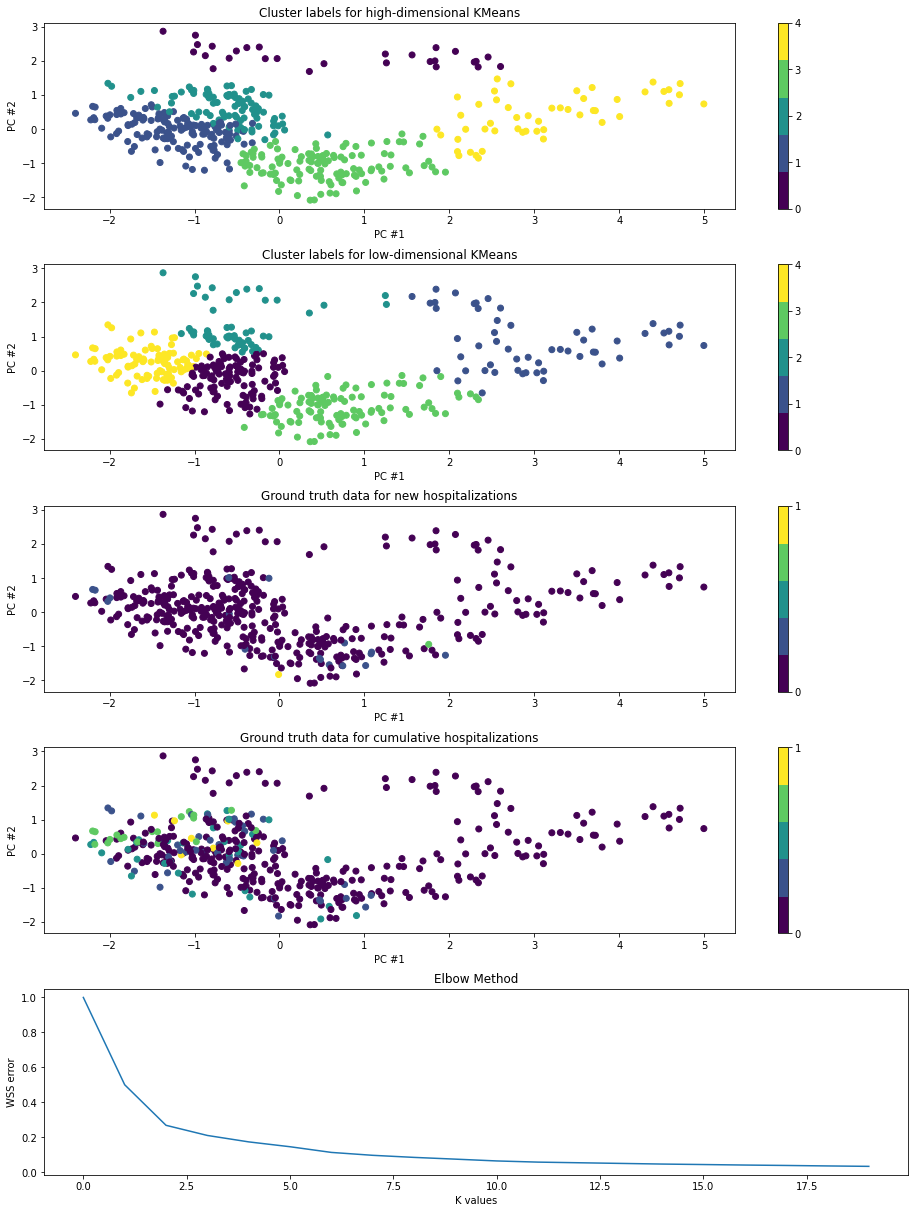

The sum squared error at k= 5 is 14.597963941765911 %
Report: The KMeans algorithm is an unsupervised learning algorithm wherewe use the features & labels to cluster data. We can see that in higherdimensions the algorithm is less accurate than in lower dimensionsin clustering. Furthermore, the Elbow method is used to determine optimalK values. Our algorithm takes in a value of k and kmax to plot the Within cluster sum squared error "WSS" and is plotted against values of k to kmax.The metric used to determine this error is euclidean distance.The error is significantly low around a value of k=5, with an error of 14.5%.


'KMeans DONE'

In [7]:
loader.run_Kmeans(k=5, kmax=20)